# Подключение зависимостей, объявление констант и функций

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as m

In [2]:
GL_A = 1/30
GL_B = 1/15
GL_xi = 1/20
GL_epsilon = 1e-4

In [3]:
x_0 = 0
x_n = m.pi
y_0 = np.array([[GL_B * m.pi], [GL_A * m.pi]])

In [4]:
def norm(v):
    return sum(x[0] ** 2 for x in v) ** .5

In [5]:
def f(x, y):
    return np.matmul(np.array([[0, GL_A], [-GL_B, 0]]), y)

In [6]:
def solution_in_cauchy_form(x, x0, y0):
    c = (GL_A * GL_B) ** .5
    return np.matmul(np.array([
        [m.cos(c * (x - x0)), (GL_A / GL_B) ** .5 * m.sin(c * (x - x0))],
        [-(GL_B / GL_A) ** .5 * m.sin(c * (x - x0)), m.cos(c * (x - x0))]
    ]), y0)

# Часть №1. Расчетные схемы метода Рунге-Кутты с постоянным шагом

## 1.1

In [7]:
def runge_kutta_second_order_method(func, x_k, y_k, h):
    k1 = h * func(x_k, y_k)
    k2 = h * func(x_k + GL_xi * h, y_k + GL_xi * k1)
    return y_k + (1 - 1 / (2*GL_xi)) * k1 + 1 / (2 * GL_xi) * k2

In [8]:
def solve_ode_with_constant_step(method, func, x_0, y_0, step, number_of_steps, result_type='all_points'):
    res = [[], []]
    y_curr = y_0
    for k in range(1, number_of_steps + 1):
        x_curr = x_0 + k * step
        y_curr = method(func, x_curr, y_curr, step)
        res[0] += [x_curr]
        res[1] += [y_curr]
    if result_type == 'all_points':
        return res
    elif result_type == 'last_point':
        return [res[0][-1], res[1][-1]]

## 1.2

In [9]:
def solve_ode_with_runge_error_estimate(method, s, func, x_0, y_0, x_n, initial_step, eps):
    n = int((x_n - x_0) / initial_step)
    solution1 = solve_ode_with_constant_step(method, func, x_0, y_0, initial_step, n, 'last_point')
    solution2 = solve_ode_with_constant_step(method, func, x_0, y_0, initial_step / 2, 2 * n)

    error = norm(solution2[1][-1] - solution1[1]) / (1 - 2 ** -s)
    h_eps = initial_step / 2 * ((2 ** s - 1) * eps / norm(solution2[1][-1] - solution1[1])) ** (1 / s)

    return solution2, error, h_eps

In [10]:
def solve_ode_with_step_choice(method, s, func, x_0, y_0, x_n, eps):
    length = x_n - x_0
    initial_step = length
    error = eps * 2
    while error > eps:
        solution, error, initial_step = solve_ode_with_runge_error_estimate(method, s, func, x_0, y_0, x_n, initial_step, eps)
        initial_step = length / m.ceil(length / initial_step)
    return solution, error

In [11]:
sol, err = solve_ode_with_step_choice(runge_kutta_second_order_method, 2, f, x_0, y_0, x_n, GL_epsilon)
xs = sol[0]
ys = sol[1]
true_error = [m.log10(norm(solution_in_cauchy_form(xs[k], x_0, y_0) - ys[k])) for k in range(len(xs))]

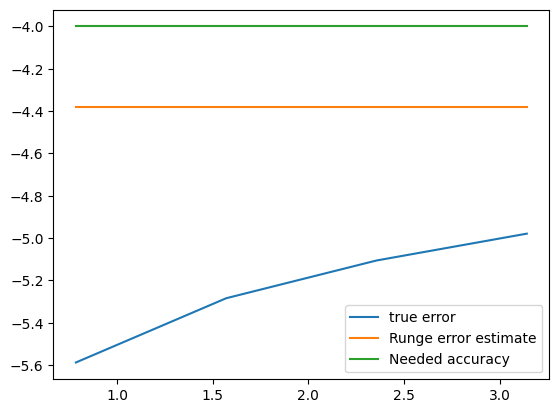

In [12]:
plt.plot(xs, true_error, label="true error")
plt.plot([xs[0], xs[-1]], [m.log10(err)] * 2, label="Runge error estimate")
plt.plot([xs[0], xs[-1]], [m.log10(GL_epsilon)] * 2, label="Needed accuracy")
plt.legend()
plt.show()

# Часть №2. Расчетные схемы метода Рунге-Кутты с автоматическим выбором шага

In [13]:
def runge_local_error_estimate(method, s, func, x_j, y_j, h):
    y1 = method(func, x_j, y_j, h)
    y2_1 = method(func, x_j + h / 2, y2_0 := method(func, x_j, y_j, h / 2), h / 2)

    error1 = (y2_1 - y1) / (1 - 2 ** -s)
    error2 = (y2_1 - y1) / (2 ** s - 1)
    return ([x_j + h, y1], error1), ([x_j + h, y2_1], error2)

In [14]:
def solve_ode_with_auto_step_choice(method, s, func, x_0, y_0, x_n, eps):
    length = x_n - x_0
    *_, curr_step = solve_ode_with_runge_error_estimate(method, s, func, x_0, y_0, x_n, length, eps)

    res = [[], []]
    local_error = []
    curr_x = x_0
    curr_y = y_0
    while (x_n - curr_x) > 1e-12:
        if curr_x + curr_step > x_n:
            curr_step = x_n - curr_x
        solution1, solution2 = runge_local_error_estimate(method, s, func, curr_x, curr_y, curr_step)
        if norm(solution1[1]) > eps * 2 ** s:
            curr_step /= 2
            continue
        elif norm(solution1[1]) > eps:
            res[0] += [solution2[0][0]]
            res[1] += [solution2[0][1]]
            local_error += [norm(solution2[1])]
            curr_step /= 2
        elif norm(solution1[1]) >= eps / 2 ** (s + 1):
            res[0] += [solution1[0][0]]
            res[1] += [solution1[0][1]]
            local_error += [norm(solution1[1])]
        else:
            res[0] += [solution1[0][0]]
            res[1] += [solution1[0][1]]
            local_error += [norm(solution1[1])]
            curr_step *= 2

        curr_x = res[0][-1]
        curr_y = res[1][-1]

    return res, local_error

In [15]:
sol, loc_err = solve_ode_with_auto_step_choice(runge_kutta_second_order_method, 2, f, x_0, y_0, x_n, 1e-5)
xs = sol[0]
ys = sol[1]

true_full_error = [m.log10(norm(solution_in_cauchy_form(xs[k], x_0, y_0) - ys[k])) for k in range(len(xs))]
true_local_error = [m.log10(norm(solution_in_cauchy_form(xs[0], x_0, y_0) - ys[0]))] + [m.log10(norm(solution_in_cauchy_form(xs[k + 1], xs[k], ys[k]) - ys[k + 1])) for k in range(len(xs) - 1)]
loc_err = list(map(m.log10, loc_err))

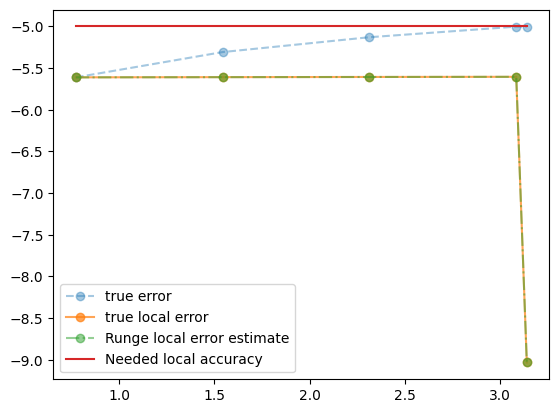

In [16]:
plt.plot(xs, true_full_error, '--o', label="true error", alpha=.4)
plt.plot(xs, true_local_error, '-o', label="true local error", alpha=.7)
plt.plot(xs, loc_err, '-.o', label="Runge local error estimate", alpha=.5)
plt.plot([xs[0], xs[-1]], [m.log10(1e-5)] * 2, label="Needed local accuracy")
plt.legend()
plt.show()

# Часть №3. Анализ эффективности методов Рунге-Кутты

## 3.1

In [17]:
def runge_kutta_third_order_method(func, x_k, y_k, h):
    k1 = h * func(x_k, y_k)
    k2 = h * func(x_k + h / 2, y_k + k1 / 2)
    k3 = h * func(x_k + h, y_k - k1 + 2 * k2)
    return y_k + k1 / 4 + 3 / 4 * k3

In [18]:
def one_sixth_rule(func, x_k, y_k, h):
    k1 = h * func(x_k, y_k)
    k2 = h * func(x_k + h / 2, y_k + k1 / 2)
    k3 = h * func(x_k + h / 2, y_k + k2 / 2)
    k4 = h * func(x_k + h, y_k + k3)
    return y_k + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

## 3.2

In [19]:
def show_graphics1(color, method_name, *args):
    sol, err = solve_ode_with_step_choice(*args)
    xs = sol[0]
    ys = sol[1]
    true_error = [m.log10(norm(solution_in_cauchy_form(xs[k], x_0, y_0) - ys[k])) for k in range(len(xs))]
    
    plt.plot(xs, true_error, '--', label=f"true error ({method_name})", color=color, alpha=.5)
    plt.plot([xs[0], xs[-1]], [m.log10(err)] * 2, label=f"Runge error estimate ({method_name})", color=color)

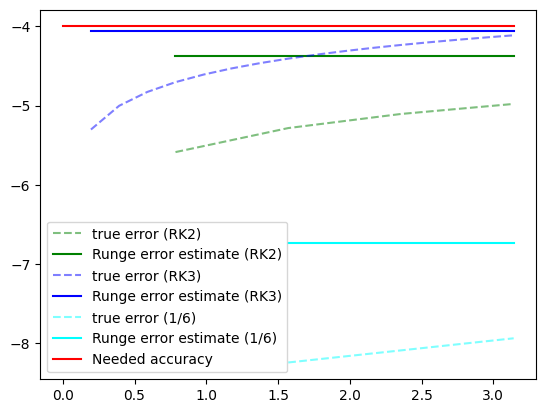

In [20]:
epsilon = GL_epsilon

show_graphics1('green', "RK2", runge_kutta_second_order_method, 2, f, x_0, y_0, x_n, epsilon)
show_graphics1('blue', "RK3", runge_kutta_third_order_method, 3, f, x_0, y_0, x_n, epsilon)
show_graphics1('cyan', "1/6", one_sixth_rule, 4, f, x_0, y_0, x_n, epsilon)
plt.plot([x_0, x_n], [m.log10(epsilon)] * 2, label="Needed accuracy", color='red')
plt.legend()
plt.show()

## 3.3

In [21]:
epsilon = 1e-8
method1 = solve_ode_with_auto_step_choice(runge_kutta_second_order_method, 2, f, x_0, y_0, x_n, epsilon)
method2 = solve_ode_with_auto_step_choice(runge_kutta_third_order_method, 3, f, x_0, y_0, x_n, epsilon)
method3 = solve_ode_with_auto_step_choice(one_sixth_rule, 4, f, x_0, y_0, x_n, epsilon)

### 3.3.1

In [22]:
def get_h(method_data):
    xs = method_data[0][0]
    hs = list([xs[k] - xs[k-1] for k in range(1, len(xs))])

    return xs[1:], hs

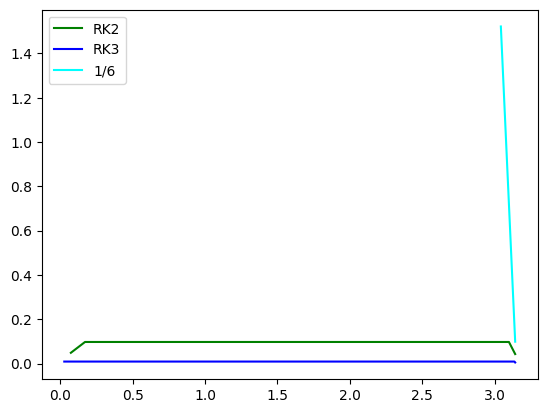

In [23]:
plt.plot(*get_h(method1), label="RK2", color='green')
plt.plot(*get_h(method2), label="RK3", color='blue')
plt.plot(*get_h(method3), label="1/6", color='cyan')
plt.legend()
plt.show()

### 3.3.2

In [24]:
def get_local_error_and_true_local_error(method_data):
    (xs, ys), local_error = method_data
    true_local_error = [norm(solution_in_cauchy_form(xs[0], x_0, y_0) - ys[0])] + [norm(solution_in_cauchy_form(xs[k + 1], xs[k], ys[k]) - ys[k + 1]) for k in range(len(xs) - 1)]

    return xs, list([true_local_error[k] / local_error[k] for k in range(len(xs))])

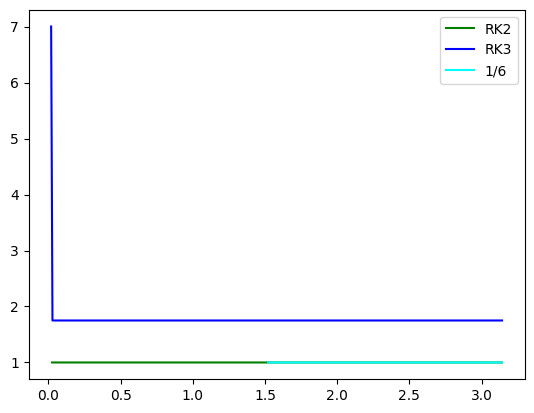

In [25]:
plt.plot(*get_local_error_and_true_local_error(method1), label="RK2", color='green')
plt.plot(*get_local_error_and_true_local_error(method2), label="RK3", color='blue')
plt.plot(*get_local_error_and_true_local_error(method3), label="1/6", color='cyan')
plt.legend()
plt.show()

### 3.3.3

In [26]:
cache = {}
def cache_function(function):
    def res(x, y):
        global cache

        hash_y = tuple([x, *[z[0] for z in y]])
        if hash_y not in cache[function]:
            cache[function][hash_y] = function(x, y)
        return cache[function][hash_y]

    global cache
    cache[function] = {}

    return res

In [27]:
res = [[], [], []]
for j in range(1, 6):
    solve_ode_with_step_choice(runge_kutta_second_order_method, 2, cache_function(f), x_0, y_0, x_n, 10 ** -j)
    res[0] += [len(cache[f])]
    solve_ode_with_step_choice(runge_kutta_third_order_method, 3, cache_function(f), x_0, y_0, x_n, 10 ** -j)
    res[1] += [len(cache[f])]
    solve_ode_with_step_choice(one_sixth_rule, 4, cache_function(f), x_0, y_0, x_n, 10 ** -j)
    res[2] += [len(cache[f])]

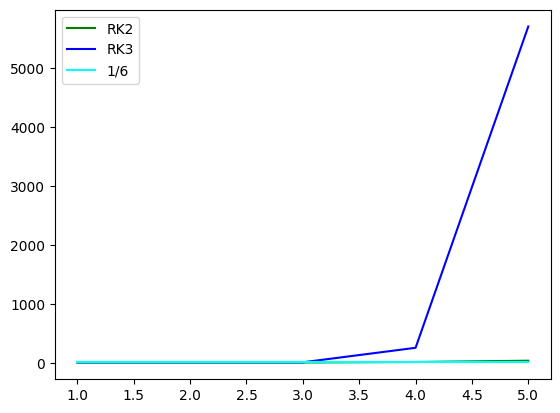

In [28]:
plt.plot(range(1, 6), res[0], label="RK2", color='green')
plt.plot(range(1, 6), res[1], label="RK3", color='blue')
plt.plot(range(1, 6), res[2], label="1/6", color='cyan')
plt.legend()
plt.show()